In [1]:
# === Recreate val split, run inference, compute per-class metrics ===
# Edit these:
DATA_FILE = "C:/Users/chris/Desktop/Documents/Code/MultimodalDataChallenge2025/metadata.csv"
IMAGE_DIR = "A:/FungiImages/FungiImages" # root containing fungi_train/*
CKPT_DIR  = "C:/Users/chris/Desktop/Documents/Code/MultimodalDataChallenge2025/checkpoints/" # where best_accuracy.pth lives

import os, pandas as pd, numpy as np
from pathlib import Path
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision import models
from PIL import Image

# --- Transforms (valid) ---
def get_valid_tf():
    w, h = 224, 224
    return Compose([Resize(w, h),
                    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                    ToTensorV2()])

# --- Dataset ---
class FungiDataset(Dataset):
    def __init__(self, df, root, transform):
        self.df = df.reset_index(drop=True)
        self.root, self.t = root, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        fp = self.df["filename_index"].iloc[i].strip()
        y  = int(self.df["taxonID_index"].iloc[i])  # <- restore label extraction
        path = os.path.join(self.root, fp)
        #print(f"[DBG] idx={i} -> {path}")

        if not os.path.exists(path):
            raise FileNotFoundError(f"Image not found: {path}. Check IMAGE_DIR.")

        if self.t is None:
            raise RuntimeError("Transform is None (get_valid_tf() not applied).")

        try:
            with Image.open(path) as img:
                im = np.array(img.convert("RGB"))
            im = self.t(image=im)["image"]
            return im, y, fp
        except Exception as e:
            raise RuntimeError(f"__getitem__ failed for {path}: {type(e).__name__}: {e}")


# --- Recreate EXACT split ---
df = pd.read_csv(DATA_FILE)
df["filename_index"] = df["filename_index"].astype(str).str.strip()
train_df_all = df[df["filename_index"].str.startswith("fungi_train")].dropna(subset=["taxonID_index"]).copy()
train_df_all["taxonID_index"] = train_df_all["taxonID_index"].astype(int)

train_df, val_df = train_test_split(train_df_all, test_size=0.2, random_state=42)

# --- Model ---
num_classes = train_df_all["taxonID_index"].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
state_path = os.path.join(CKPT_DIR, "best_accuracy.pth")
model.load_state_dict(torch.load(state_path, map_location=device))
model.to(device).eval()

# --- Inference on VAL ---
val_ds = FungiDataset(val_df, IMAGE_DIR, transform=get_valid_tf())
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)


c:\Users\chris\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chris\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm

y_true, y_pred, names = [], [], []
with torch.no_grad():
    total_batches = len(val_loader)
    limit_batches = max(1, int(total_batches * 0.1))  # 10% of batches

    for batch_idx, (x, y, fn) in enumerate(tqdm(val_loader, desc="Validating", unit="batch")):
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())
        names.extend(fn)

        # if batch_idx + 1 >= limit_batches:
        #     print(f"Stopping early after {limit_batches} batches ({100*limit_batches/total_batches:.1f}% of data).")
        #     break

y_true = np.array(y_true); y_pred = np.array(y_pred)

# --- Metrics ---
acc = accuracy_score(y_true, y_pred)
# ensure we include all classes (even if some are missing in y_pred)
labels_sorted = sorted(pd.unique(train_df_all["taxonID_index"]))

Validating:   9%|▉         | 15/162 [01:20<13:06,  5.35s/batch]

Stopping early after 16 batches (9.9% of data).


In [4]:
rep = classification_report(
    y_true, y_pred,
    labels=labels_sorted,
    output_dict=True,
    zero_division=0
)
rep_df = pd.DataFrame(rep).transpose()

# select ROWS whose index is digits (per-class rows)
per_class = rep_df.loc[rep_df.index.map(str).str.fullmatch(r"\d+")].copy()
per_class.index = per_class.index.astype(int)

# reindex to include every class in labels_sorted (missing rows become NaN)
per_class = per_class.reindex(labels_sorted)

per_class = per_class.rename(columns={"precision":"prec","recall":"rec","f1-score":"f1","support":"n"})


labels_sorted = sorted(per_class.index.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
diag = np.diag(cm).astype(float)
row_sum = cm.sum(axis=1).astype(float)
per_class["accuracy"] = np.divide(diag, row_sum, out=np.zeros_like(diag), where=row_sum>0)
# Misclassifications list
mis = pd.DataFrame({
    "filename_index": names,
    "y_true": y_true,
    "y_pred": y_pred
})
mis = mis[mis["y_true"] != mis["y_pred"]]

# --- Save ---
out = Path(CKPT_DIR)
out.mkdir(parents=True, exist_ok=True)
per_class.to_csv(out/"val_per_class_metrics.csv", index_label="class_index")
pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted).to_csv(out/"val_confusion_matrix.csv")
rep_df.loc[["accuracy","macro avg","weighted avg"]].to_csv(out/"val_overall_metrics.csv")
mis.to_csv(out/"val_misclassified.csv", index=False)

print(f"VAL accuracy: {acc:.4f}")
print(f"Saved: {out/'val_per_class_metrics.csv'}, {out/'val_confusion_matrix.csv'}, {out/'val_overall_metrics.csv'}, {out/'val_misclassified.csv'}")

VAL accuracy: 0.5352
Saved: C:\Users\chris\Desktop\Documents\Code\MultimodalDataChallenge2025\checkpoints\val_per_class_metrics.csv, C:\Users\chris\Desktop\Documents\Code\MultimodalDataChallenge2025\checkpoints\val_confusion_matrix.csv, C:\Users\chris\Desktop\Documents\Code\MultimodalDataChallenge2025\checkpoints\val_overall_metrics.csv, C:\Users\chris\Desktop\Documents\Code\MultimodalDataChallenge2025\checkpoints\val_misclassified.csv


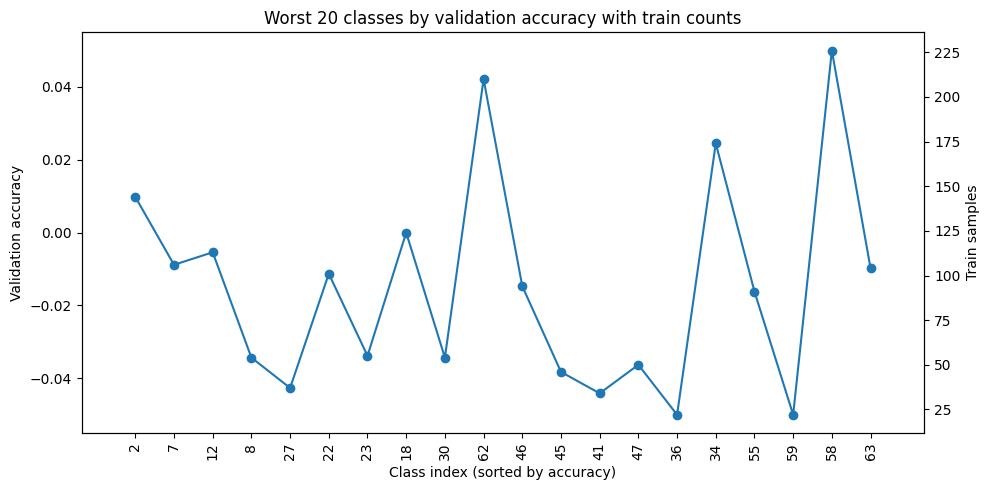

In [8]:
import matplotlib.pyplot as plt
# Build summary: per-class validation accuracy + train counts
train_counts = train_df["taxonID_index"].value_counts().rename_axis("class_index").sort_index()
summary = per_class[["accuracy"]].copy()
summary.index.name = "class_index"
summary = summary.join(train_counts.rename("train_count"))

# Sort by accuracy ascending (worst first)
summary_sorted = summary.sort_values("accuracy", ascending=True)

# Pick worst-K
K = 20
worst = summary_sorted.head(K).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
x = np.arange(len(worst))

ax1.bar(x, worst["accuracy"], color="tab:red", alpha=0.7, label="Val accuracy")
ax1.set_ylabel("Validation accuracy")
ax1.set_xlabel("Class index (sorted by accuracy)")
ax1.set_xticks(x)
ax1.set_xticklabels(worst["class_index"], rotation=90)

ax2.plot(x, worst["train_count"], marker="o", color="tab:blue", label="Train count")
ax2.set_ylabel("Train samples")

plt.title(f"Worst {K} classes by validation accuracy with train counts")
plt.tight_layout()
plt.show()


In [ ]:
CSV_FILE = "C:/Users/chris/Desktop/Documents/Code/MultimodalDataChallenge2025/checkpoints/val_per_class_metrics.csv"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Paths ===
CSV_FILE = "C:/Users/chris/Desktop/Documents/Code/MultimodalDataChallenge2025/checkpoints/val_per_class_metrics.csv"
METADATA_FILE = "C:/path/to/metadata.csv"                   # original metadata

# Load accuracy CSV
summary = pd.read_csv(CSV_FILE, index_col="class_index")

# If train_count missing, recompute from metadata
if "train_count" not in summary.columns:
    meta = pd.read_csv(METADATA_FILE)
    meta["filename_index"] = meta["filename_index"].astype(str).str.strip()
    train_df = meta[meta["filename_index"].str.startswith("fungi_train")].dropna(subset=["taxonID_index"]).copy()
    train_df["taxonID_index"] = train_df["taxonID_index"].astype(int)
    train_counts = train_df["taxonID_index"].value_counts().rename_axis("class_index").sort_index()
    summary = summary.join(train_counts.rename("train_count"), how="left").fillna({"train_count": 0}).astype({"train_count": int})

# Sort worst → best
summary_sorted = summary.sort_values("accuracy", ascending=True)

# Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
x = np.arange(len(summary_sorted))

ax1.bar(x, summary_sorted["accuracy"], color="tab:red", alpha=0.7, label="Val accuracy")
ax1.set_ylabel("Validation accuracy")
ax1.set_xlabel("Class index (sorted by accuracy)")
ax1.set_xticks(x)
ax1.set_xticklabels(summary_sorted.index, rotation=90)

ax2.plot(x, summary_sorted["train_count"], marker="o", color="tab:blue", label="Train count")
ax2.set_ylabel("Train samples")

plt.title("Classes sorted by validation accuracy with train counts")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:/path/to/val_accuracy_with_train_counts.csv'